In [1]:
import numpy as np 
import pandas as pd 
from gensim.models import FastText
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix , classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as tfl
import tensorflow.keras.models as tfm 

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

from gensim.models import Word2Vec
from gensim.test.utils import common_texts 

from sklearn.metrics.pairwise import cosine_similarity

2024-04-27 17:35:14.803612: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 17:35:14.803716: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 17:35:14.960099: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
df = pd.read_csv(
    '/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv' 
    , encoding = 'ISO-8859-1' , names = DATASET_COLUMNS)

df.head(6)

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [3]:
class preprocessing:
    def __init__(self,text):
        self.text=text
        self.words=None
    def clear(self):
        clean = re.compile('<.*?>')
        self.text =  re.sub(clean, '', self.text)
        self.text= re.sub(r"[^a-zA-Z]"," ",self.text)
        self.text = re.sub(r'\s+', ' ', self.text)
    def Normalization(self):
        self.text=self.text.lower()
#         print(self.text)
    def Tokenization(self):
        self.words = word_tokenize(self.text)
#         print(self.words)
    def del_stop_words(self):
        stop_words = set(stopwords.words('english'))
        self.words=[word for word in self.words if (word not in stop_words)]
    def stemming(self):
        stemmer = PorterStemmer()
        self.words = [stemmer.stem(word) for word in self.words]
    def unique_words(self):
        return set(self.words)
    def return_string(self):
        return ' '.join(self.words)
    def del_char (self):
        self.words=[word for word in self.words if (len(word)>1)]
        return self.words

In [4]:
def clean_document (document):
    cleaner = preprocessing(document)
    cleaner.clear()
    cleaner.Normalization()
    cleaner.Tokenization()
    cleaner.del_stop_words()
    output = cleaner.del_char()
    return output

### Take subset from the data 25000 positive sample and 25000 Negative Sample 

In [5]:
pos = df[df['sentiment'] == 4].sample(25000)
neg = df[df['sentiment'] == 0].sample(25000)

df = pd.concat([pos , neg])

In [6]:
df['text'] = df['text'].apply(clean_document)

In [7]:
df = df[df['text'].str.len() != 0 ]

In [8]:
word2vec_model = Word2Vec(sentences=df['text'], vector_size=100, window=5, min_count=1, sg=0)


### Delete unnecessary columns

In [9]:
df.drop(columns = ['ids', 'date', 'flag', 'user'] , inplace = True)

In [10]:
df.shape

(49980, 2)

In [14]:
df['sentiment'] = np.where(df['sentiment'] > 0, 1, 0)


In [15]:
df.shape

(49980, 2)

In [16]:
max_len = df['text'].str.len().max()
min_len = df['text'].str.len().min()

In [17]:
def embed_text(row, model):
    embedded_words = [model.wv[word] for word in row]
    return embedded_words

In [18]:
embedded_sequences = [embed_text(row, word2vec_model) for row in df['text']]

In [19]:
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(embedded_sequences, maxlen=max_len, padding='post', dtype='float32')


In [20]:
padded_sequences.shape

(49980, 30, 100)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['sentiment'], test_size=0.33, random_state=42)

### LeNet5 Model

In [46]:
model = tfm.Sequential()
model.add(tfl.Input((30 , 100)))
model.add(tfl.Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(tfl.MaxPooling1D(pool_size=2))
model.add(tfl.Flatten())
model.add(tfl.Dense(64, activation='relu'))
model.add(tfl.Dense(1, activation='sigmoid'))
print(model.summary())          


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 23, 32)         │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 11, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 352)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        22,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,289 (188.63 KB)

 Trainable params: 48,289 (188.63 KB)

 Non-trainable params: 0 (0.00 B)

None


In [47]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_split=0.1, shuffle=True)


Epoch 1/10
942/942 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5645 - loss: 0.6832 - val_accuracy: 0.5960 - val_loss: 0.6641
Epoch 2/10
942/942 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6003 - loss: 0.6612 - val_accuracy: 0.5909 - val_loss: 0.6573
Epoch 3/10
942/942 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6054 - loss: 0.6532 - val_accuracy: 0.6047 - val_loss: 0.6511
Epoch 4/10
942/942 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6177 - loss: 0.6434 - val_accuracy: 0.5990 - val_loss: 0.6583
Epoch 5/10
942/942 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6251 - loss: 0.6412 - val_accuracy: 0.6091 - val_loss: 0.6482
Epoch 6/10
942/942 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6275 - loss: 0.6362 - val_accuracy: 0.6017 - val_loss: 0.6566
Epoch 7/10
942/942 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6285 - loss: 0.6316 - val_accuracy: 0.6085 - val_loss: 0.6505
Epoch 8/10
942/942 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6391 - loss: 0.6249 - val_accuracy: 0.

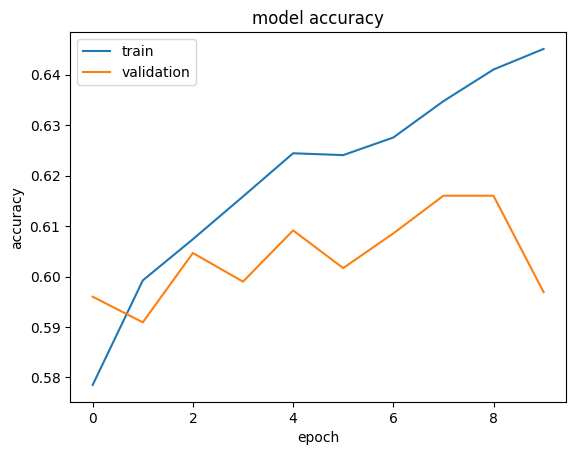

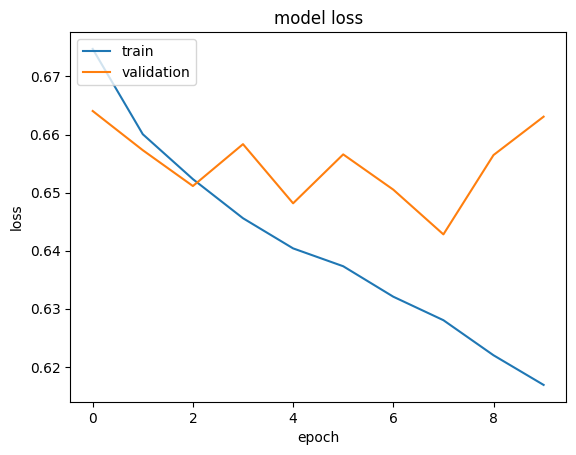

In [48]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [30]:
from sklearn.metrics import classification_report


In [49]:
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print(classification_report(y_test , y_pred))

516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.56      0.83      0.67      8226
           1       0.68      0.36      0.47      8268

    accuracy                           0.60     16494
   macro avg       0.62      0.60      0.57     16494
weighted avg       0.62      0.60      0.57     16494



In [51]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Concatenate, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model


In [52]:
def inception_module(x, filters):
    branch_1x1 = Conv1D(filters, kernel_size=1, padding='same', activation='relu')(x)
    
    branch_3x3 = Conv1D(filters, kernel_size=3, padding='same', activation='relu')(x)
    
    branch_5x5 = Conv1D(filters, kernel_size=5, padding='same', activation='relu')(x)
    
    branch_pool = MaxPooling1D(pool_size=3, strides=1, padding='same')(x)
    branch_pool = Conv1D(filters, kernel_size=1, padding='same', activation='relu')(branch_pool)
    
    concat = Concatenate()([branch_1x1, branch_3x3, branch_5x5, branch_pool])
    return concat


In [56]:
def build_inception_text(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    
    x = Conv1D(64, kernel_size=3, padding='same', activation='relu')(input_layer)
    x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)
    
    x = inception_module(x, filters=64)
    x = inception_module(x, filters=128)
    
    x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)

    x = inception_module(x, filters=256)
    x = inception_module(x, filters=512)
    
    x = GlobalAveragePooling1D()(x)
    
    x = Dense(512, activation='relu')(x)
    output_layer = Dense(num_classes, activation='sigmoid')(x)
    

    model = Model(input_layer, output_layer)
    return model


In [57]:
 model = build_inception_text(X_train[0].shape, 1)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 30, 100)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 30, 64)    │     19,264 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 15, 64)    │          0 │ conv1d_21[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_11    │ (None, 15, 64)    │          0 │ max_pooling1d_10… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 15, 64)    │      4,160 │ max_pooling1d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 15, 64)    │     12,352 │ max_pooling1d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 15, 64)    │     20,544 │ max_pooling1d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 15, 64)    │      4,160 │ max_pooling1d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 15, 256)   │          0 │ conv1d_22[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_23[0][0],  │
│                     │                   │            │ conv1d_24[0][0],  │
│                     │                   │            │ conv1d_25[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_12    │ (None, 15, 256)   │          0 │ concatenate_4[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 15, 128)   │     32,896 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 15, 128)   │     98,432 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 15, 128)   │    163,968 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 15, 128)   │     32,896 │ max_pooling1d_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 15, 512)   │          0 │ conv1d_26[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_27[0][0],  │
│                     │                   │            │ conv1d_28[0][0],  │
│                     │                   │            │ conv1d_29[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_13    │ (None, 8, 512)    │          0 │ concatenate_5[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_14    │ (None, 8, 512)    │          0 │ max_pooling1d_13… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 8, 256)    │    131,328 │ max_pooling1d_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 8, 256)    │    393,472 │ max_pooling1d_13

 Total params: 7,994,945 (30.50 MB)

 Trainable params: 7,994,945 (30.50 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
history = model.fit(X_train, y_train, epochs=50, validation_split=0.1, shuffle=True)


Epoch 1/50
 12/942 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.4469 - loss: 1.2656

W0000 00:00:1714240176.370141     201 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


942/942 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5432 - loss: 0.7079

W0000 00:00:1714240193.397405     203 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714240194.663767     203 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


942/942 ━━━━━━━━━━━━━━━━━━━━ 29s 22ms/step - accuracy: 0.5432 - loss: 0.7079 - val_accuracy: 0.6082 - val_loss: 0.6636
Epoch 2/50
 13/942 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.5382 - loss: 0.6804

W0000 00:00:1714240197.242702     203 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


942/942 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.6024 - loss: 0.6588 - val_accuracy: 0.5873 - val_loss: 0.6557
Epoch 3/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.6125 - loss: 0.6485 - val_accuracy: 0.6285 - val_loss: 0.6512
Epoch 4/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.6264 - loss: 0.6398 - val_accuracy: 0.6357 - val_loss: 0.6262
Epoch 5/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.6278 - loss: 0.6332 - val_accuracy: 0.6390 - val_loss: 0.6253
Epoch 6/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.6449 - loss: 0.6184 - val_accuracy: 0.6351 - val_loss: 0.6280
Epoch 7/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.6519 - loss: 0.6139 - val_accuracy: 0.6486 - val_loss: 0.6206
Epoch 8/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.6540 - loss: 0.6087 - val_accuracy: 0.6453 - val_loss: 0.6197
Epoch 9/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.6633 - loss: 0.5968 - val_accurac

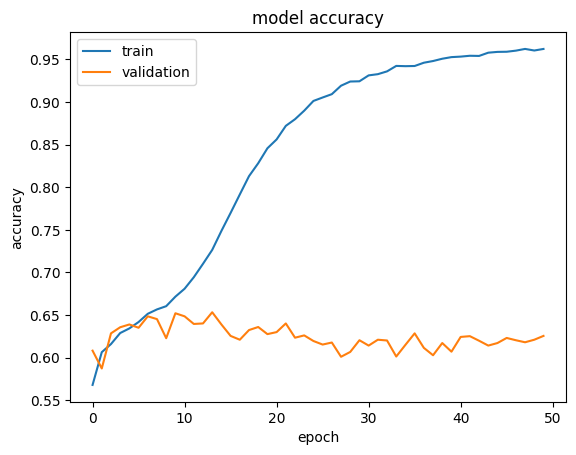

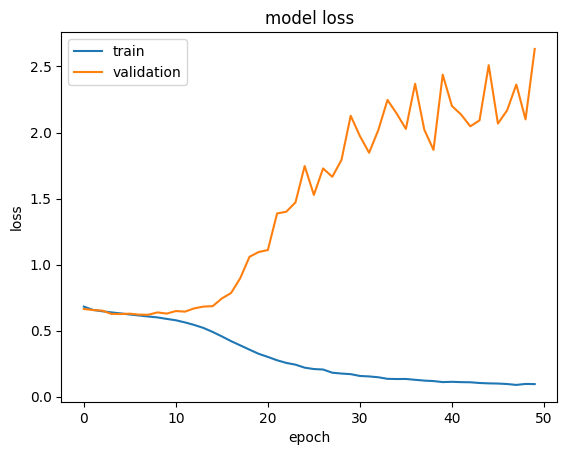

In [59]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [61]:
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print(classification_report(y_test , y_pred))

516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.61      0.61      0.61      8226
           1       0.61      0.62      0.62      8268

    accuracy                           0.61     16494
   macro avg       0.61      0.61      0.61     16494
weighted avg       0.61      0.61      0.61     16494

